# KISS-ICP running on the Newer College Dataset

The whole purpose of this notebook is to have a reproducable entry point for the experiments of the paper. You can also modify the system and just run this notebook to inspect the overall results.

We use the "old" version of the newer college dataset, the one that uses the OS1-64 LiDAR. There are 2 public sequences, the "long_experiment" is only avaiable as rosbag file.

## Expected dataset layout

```sh
newer_college
  ├── 01_short_experiment
  │   ├── ground_truth
  │   │   ├── poses_kitti_format.txt
  │   │   └── registered_poses.csv
  │   ├── raw_format
  │   │   ├── ouster_imu
  │   │   ├── ouster_scan
  │   │   │   ├── cloud_1583836591_182590976.pcd
  │   │   │   ├── cloud_1583836591_282592512.pcd
  │   │   │   ├── ...
  │   │   └── realsense_imu
  │   └── time_offsets
  │       └── time_offsets.csv
  ├── 02_long_experiment
  │   ├── ground_truth
  │   │   └── registered_poses.csv
  │   ├── raw_format
  │   │   ├── convert_to_shitty_format.py
  │   │   └── ouster_scan
  │   └── rosbag
  │       ├── rooster_2020-03-10-11-36-51_0.bag
  │       ├── rooster_2020-03-10-11-39-38_1.bag
  │       ├── ...

```

In [1]:
# Install KISS-ICP and Plotting tools
%pip install kiss-icp ipympl evo >/dev/null

import os
from pathlib import Path

import kiss_icp
import matplotlib.pyplot as plt
import numpy as np
from evo.tools import plot
from kiss_icp.config import load_config
from kiss_icp.datasets import dataset_factory
from kiss_icp.pipeline import OdometryPipeline
from rich import print

%autoreload 2
%matplotlib inline
%matplotlib widget

Note: you may need to restart the kernel to use updated packages.


In [2]:
data_root = os.environ.get("DATASETS")
data_dir = Path(os.path.join(data_root, "newer_college/2020-ouster-os1-64-realsense"))
cfg_file = os.path.join(os.path.dirname(kiss_icp.__file__), "config/default.yaml")

print(f"Reading datasets from : {data_root}")
print(f"Configuration:")
print(load_config(cfg_file))

Reading datasets from : /home/ivizzo/data/

Configuration:

{
    'out_dir': 'results',
    'use_cache': True,
    'data': {
        'lidar_frequency': 10.0,
        'preprocess': True,
        'max_range': 100.0,
        'min_range': 5.0
    },
    'mapping': {'max_points_per_voxel': 20},
    'adaptive_threshold': {'initial_threshold': 2.0, 'min_motion_th': 0.1}
}

## Custom Dataloader for the `02_long_experiment` sequence

For whatever reason this part of the dataset is only public as rosbag. So we need to do a bit of extra effort to run the experiment (but not too much ;)

It is also a nice exercise on how can you extend KISS-ICP to process data from your own dataset by simply providing a custom dataloader (just one python class!)

In [3]:
import numpy as np
import rosbag
import sensor_msgs.point_cloud2 as pc2
from kiss_icp.config import KISSConfig, load_config
from natsort import natsorted
from scipy.spatial.transform import Rotation as R


class NewerCollegeRosbag:
    def __init__(self, data_dir: Path, config: Path):
        self.config = load_config(config)
        self.data_source = os.path.join(data_dir, "")
        self.pose_file = os.path.join(
            self.data_source, "ground_truth/registered_poses.csv"
        )
        self.gt_poses = self.load_gt_poses(self.pose_file)
        self.sequence_id = "02_long_experiment"

        # process rosbag-files
        print("Processing rosbag files (this will take some time)")
        self.topic = "/os1_cloud_node/points"
        self.rosbag_dir = data_dir / "rosbag"
        self.rosbag_files = natsorted(
            [
                os.path.join(self.rosbag_dir, f)
                for f in os.listdir(self.rosbag_dir)
                if f.endswith(".bag")
            ]
        )
        self.bags = []
        self.n_scans = 0
        for rosbag_file in self.rosbag_files:
            bag = rosbag.Bag(rosbag_file, mode="r")
            self.bags.append(bag)
            self.n_scans += bag.get_message_count(topic_filters=self.topic)

        self.bag = self.bags.pop(0)
        self.msgs = self.bag.read_messages(topics=[self.topic])
        print(f"Now processing {self.bag.filename}")

    def __len__(self):
        return self.n_scans

    def __getitem__(self, idx):
        try:
            _, msg, _ = next(self.msgs)
        except StopIteration:
            self.bag.close()
            # new bagile
            self.bag = self.bags.pop(0)
            self.msgs = self.bag.read_messages(topics=[self.topic])
            print(f"Now processing {self.bag.filename}")
            _, msg, _ = next(self.msgs)

        points = np.array(list(pc2.read_points(msg, field_names=["x", "y", "z"])))
        if self.config.data.preprocess:
            points = self._preprocess(points, self.config.data)
        return points.astype(np.float64)

    @staticmethod
    def _preprocess(points, config: KISSConfig.data):
        ranges = np.linalg.norm(points, axis=1)
        filter_ = np.logical_and(ranges <= config.max_range, ranges >= config.min_range)
        return points[filter_]

    @staticmethod
    def load_gt_poses(file_path: str):
        """Taken from pyLiDAR-SLAM/blob/master/slam/dataset/nhcd_dataset.py"""
        ground_truth_df = np.genfromtxt(str(file_path), delimiter=",", dtype=np.float64)
        xyz = ground_truth_df[:, 2:5]
        qxyzw = ground_truth_df[:, 5:]

        num_poses = qxyzw.shape[0]
        poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
        poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
        poses[:, :3, 3] = xyz

        T_CL = np.eye(4, dtype=np.float32)
        T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix()
        T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32)
        poses = np.einsum("nij,jk->nik", poses, T_CL)
        poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses)
        return poses

In [4]:
from kiss_icp_eval import run_sequence


def ncd_short_sequence(int):
    return OdometryPipeline(
        dataset=dataset_factory(
            dataloader="ncd",
            data_dir=data_dir / "01_short_experiment",
            config=cfg_file,
        ),
        config=cfg_file,
    )


def ncd_long_sequence(int):
    return OdometryPipeline(
        dataset=NewerCollegeRosbag(
            data_dir=data_dir / "02_long_experiment",
            config=cfg_file,
        ),
        config=cfg_file,
    )


results = {}
run_sequence(ncd_short_sequence, sequence="01_short_experiment", results=results)
run_sequence(ncd_long_sequence, sequence="02_long_experiment", results=results)

Now evaluating sequence 01_short_experiment


  0%|                                                                                                         …

───────────────────────────────────────────────── 
                           Metric   Value   Units  
 ───────────────────────────────────────────────── 
        Average Translation Error   0.505   %      
         Average Rotational Error   0.517   deg/m  
  Absoulte Trajectory Error (ATE)   2.677   m      
  Absoulte Rotational Error (ARE)   0.021   rad    
                Average Frequency    19     Hz     
                  Average Runtime    52     ms     
 ─────────────────────────────────────────────────

Processing rosbag files (this will take some time)

Now processing /home/ivizzo/data/newer_college/2020-ouster-os1-64-realsense/02_long_experimen
t/rosbag/rooster_2020-03-10-11-36-51_0.bag

Now evaluating sequence 02_long_experiment


  0%|                                                                                                         …

Now processing /home/ivizzo/data/newer_college/2020-ouster-os1-64-realsense/02_long_experimen
t/rosbag/rooster_2020-03-10-11-39-38_1.bag

Now processing /home/ivizzo/data/newer_college/2020-ouster-os1-64-realsense/02_long_experimen
t/rosbag/rooster_2020-03-10-11-42-25_2.bag

Now processing /home/ivizzo/data/newer_college/2020-ouster-os1-64-realsense/02_long_experimen
t/rosbag/rooster_2020-03-10-11-45-12_3.bag

Now processing /home/ivizzo/data/newer_college/2020-ouster-os1-64-realsense/02_long_experimen
t/rosbag/rooster_2020-03-10-11-47-59_4.bag

Now processing /home/ivizzo/data/newer_college/2020-ouster-os1-64-realsense/02_long_experimen
t/rosbag/rooster_2020-03-10-11-50-46_5.bag

Now processing /home/ivizzo/data/newer_college/2020-ouster-os1-64-realsense/02_long_experimen
t/rosbag/rooster_2020-03-10-11-53-33_6.bag

Now processing /home/ivizzo/data/newer_college/2020-ouster-os1-64-realsense/02_long_experimen
t/rosbag/rooster_2020-03-10-11-56-20_7.bag

Now processing /home/ivizzo/data/newer_college/2020-ouster-os1-64-realsense/02_long_experimen
t/rosbag/rooster_2020-03-10-11-59-07_8.bag

Now processing /home/ivizzo/data/newer_college/2020-ouster-os1-64-realsense/02_long_experimen
t/rosbag/rooster_2020-03-10-12-01-54_9.bag

Now processing /home/ivizzo/data/newer_college/2020-ouster-os1-64-realsense/02_long_experimen
t/rosbag/rooster_2020-03-10-12-04-41_10.bag

Now processing /home/ivizzo/data/newer_college/2020-ouster-os1-64-realsense/02_long_experimen
t/rosbag/rooster_2020-03-10-12-07-28_11.bag

Now processing /home/ivizzo/data/newer_college/2020-ouster-os1-64-realsense/02_long_experimen
t/rosbag/rooster_2020-03-10-12-10-15_12.bag

Now processing /home/ivizzo/data/newer_college/2020-ouster-os1-64-realsense/02_long_experimen
t/rosbag/rooster_2020-03-10-12-13-02_13.bag

Now processing /home/ivizzo/data/newer_college/2020-ouster-os1-64-realsense/02_long_experimen
t/rosbag/rooster_2020-03-10-12-15-49_14.bag

Now processing /home/ivizzo/data/newer_college/2020-ouster-os1-64-realsense/02_long_experimen
t/rosbag/rooster_2020-03-10-12-18-36_15.bag

───────────────────────────────────────────────── 
                           Metric   Value   Units  
 ───────────────────────────────────────────────── 
        Average Translation Error   0.954   %      
         Average Rotational Error   1.183   deg/m  
  Absoulte Trajectory Error (ATE)   6.231   m      
  Absoulte Rotational Error (ARE)   0.113   rad    
                Average Frequency    14     Hz     
                  Average Runtime    71     ms     
 ─────────────────────────────────────────────────

In [5]:
from kiss_icp_eval import print_metrics_table

print_metrics_table(results)

# Experiment Results
|Metric|Value|Units|
|-:|:-:|:-|
Average Translation Error| 0.73|% |
Average Rotational Error| 0.85|deg/m |
Absoulte Trajectory Error (ATE)| 4.45|m |
Absoulte Rotational Error (ARE)| 0.07|rad |
Average Frequency| 16.50|Hz |
Average Runtime| 61.50|ms |


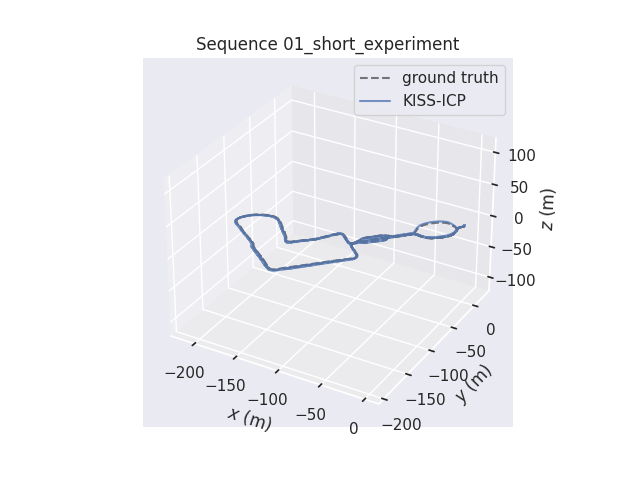

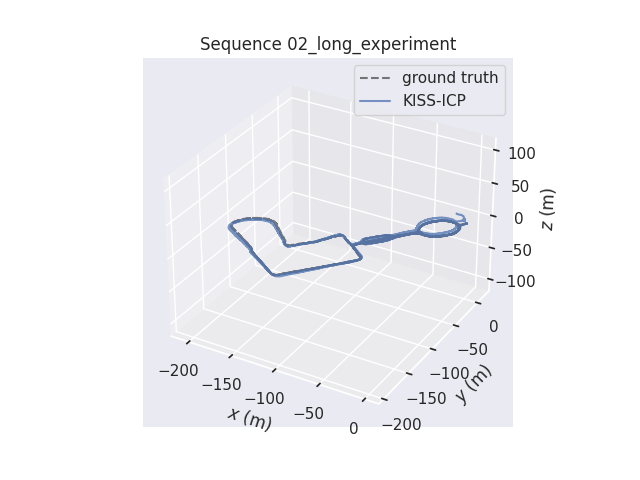

In [6]:
from kiss_icp_eval import plot_trajectories

plot_trajectories(results)